# Parallelization

In [1]:
import time

def inc(x):
    time.sleep(1)
    return x + 1

def add(x, y):
    time.sleep(1)
    return x + y

In [2]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [3]:
%%time
results = []
for x in data:
    results.append(inc(x))

CPU times: user 1.55 ms, sys: 190 µs, total: 1.74 ms
Wall time: 8.01 s


In [4]:
results

[2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
%%time
results = [inc(x) for x in data]

CPU times: user 0 ns, sys: 2.3 ms, total: 2.3 ms
Wall time: 8.01 s


In [6]:
results

[2, 3, 4, 5, 6, 7, 8, 9]

In [7]:
import os
print(os.cpu_count())

4


In [8]:
import multiprocessing as mp
print(mp.cpu_count())

4


In [9]:
workers = 4

In [10]:
import multiprocessing as mp

def parallelize(fun, data, workers):
    with mp.Pool(workers) as p:
        res = p.map(fun, data)
    return res

In [11]:
%%time
results = parallelize(inc, data, workers)

CPU times: user 11.6 ms, sys: 16.7 ms, total: 28.3 ms
Wall time: 2.03 s


In [12]:
results

[2, 3, 4, 5, 6, 7, 8, 9]

In [3]:
data1 = [(0, 1), (2, 3), (4, 5), (6, 7)]

In [14]:
# this returns an error
# results1 = parallelize(add, data1, workers)

In [15]:
def parallelize_multiple_args(fun, vec, workers):
    with mp.Pool(workers) as p:
        res = p.starmap(fun, vec)
    return res

In [16]:
%%time
results1 = parallelize_multiple_args(add, data1, workers)

CPU times: user 8.73 ms, sys: 16.9 ms, total: 25.6 ms
Wall time: 1.04 s


In [17]:
results1

[1, 5, 9, 13]

In [18]:
# this returns an error
# results = parallelize_multiple_args(inc, data, workers)

# Parallelization with Dask

In [4]:
from dask.distributed import Client, LocalCluster
from dask import delayed, compute

cluster = LocalCluster(n_workers=4)
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:41947 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


In [21]:
result = delayed(inc)(1)

In [22]:
result

Delayed('inc-b48c6015-6ec8-4ed3-b4f9-2fd64468b7f7')

In [23]:
%%time
result.compute()

CPU times: user 87.4 ms, sys: 5.5 ms, total: 92.9 ms
Wall time: 1.02 s


2

In [24]:
%%time
to_compute = [delayed(inc)(x) for x in data]

CPU times: user 2.09 ms, sys: 420 µs, total: 2.51 ms
Wall time: 2.18 ms


In [25]:
to_compute

[Delayed('inc-46fade12-bc33-4f56-ae90-a14fb05b435a'),
 Delayed('inc-5ac8ba28-12e3-4270-a643-c492e01f2784'),
 Delayed('inc-1f65cf4b-8111-431c-b7a4-e3c98f6c8573'),
 Delayed('inc-2007d989-0389-41b1-bf94-bd75a19819ae'),
 Delayed('inc-42de2177-1be9-42eb-a1d5-2275616f7cae'),
 Delayed('inc-50e04578-ba94-4edc-b255-bcbfdcba0841'),
 Delayed('inc-cf1a7936-dd85-4c21-8205-676b365a2fef'),
 Delayed('inc-46a89cbc-5789-4db4-8b0c-7b7a9d6dbef9')]

In [26]:
%%time
results = compute(to_compute)[0]

CPU times: user 181 ms, sys: 13.6 ms, total: 195 ms
Wall time: 2.04 s


In [27]:
results

[2, 3, 4, 5, 6, 7, 8, 9]

In [28]:
%%time
to_compute1 = [delayed(add)(x, y) for (x, y) in data1]

CPU times: user 2.8 ms, sys: 0 ns, total: 2.8 ms
Wall time: 2.24 ms


In [29]:
%%time
results1 = compute(to_compute1)[0]

CPU times: user 89.8 ms, sys: 13.8 ms, total: 104 ms
Wall time: 1.02 s


In [7]:
to_compute1 = []
for (x, y) in data1:
    to_compute1.append(delayed(add)(x, y))

In [8]:
results1 = compute(to_compute1)[0]

In [9]:
results1

[1, 5, 9, 13]

In [77]:
data = [1, 2, 3, 4, 5, 6, 7, 8]
to_compute = [delayed(inc)(x) for x in data]
output = delayed(sum)(to_compute)

In [78]:
output

Delayed('sum-2ac0163c-48ed-4382-842b-f7d7d70b6b2e')

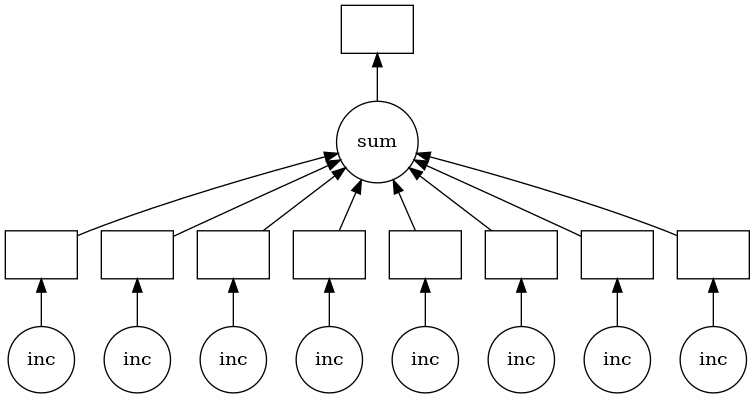

In [79]:
output.visualize(filename="DAG")

In [31]:
client.close()

In [32]:
to_compute = []
for x in data:
    to_compute.append(delayed(inc)(x))

In [33]:
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

In [34]:
%%time
z.compute()

CPU times: user 127 ms, sys: 28.6 ms, total: 156 ms
Wall time: 2.01 s


5

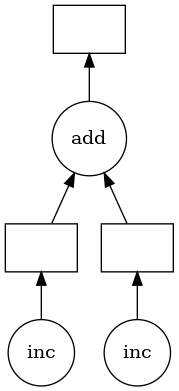

In [45]:
z.visualize(filename="DAG.png")

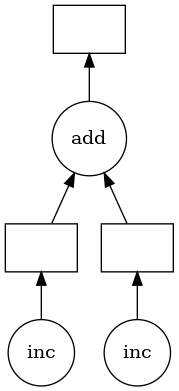

In [35]:
z.visualize()

In [36]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

In [37]:
df = pd.DataFrame({"a":[1, 1, 2, 2, 2],
                   "b":[1,2,3,4,5]})

In [38]:
ddf = dd.from_pandas(df, npartitions=2)

In [39]:
ddf

,a,b
npartitions=2,,
0,int64,int64
3,...,...
4,...,...


In [40]:
grp = ddf.groupby("a")["b"].sum()

In [41]:
grp

Dask Series Structure:
npartitions=1
    int64
      ...
Name: b, dtype: int64
Dask Name: series-groupby-sum-agg, 5 tasks

In [42]:
grp.compute()

a
1     3
2    12
Name: b, dtype: int64

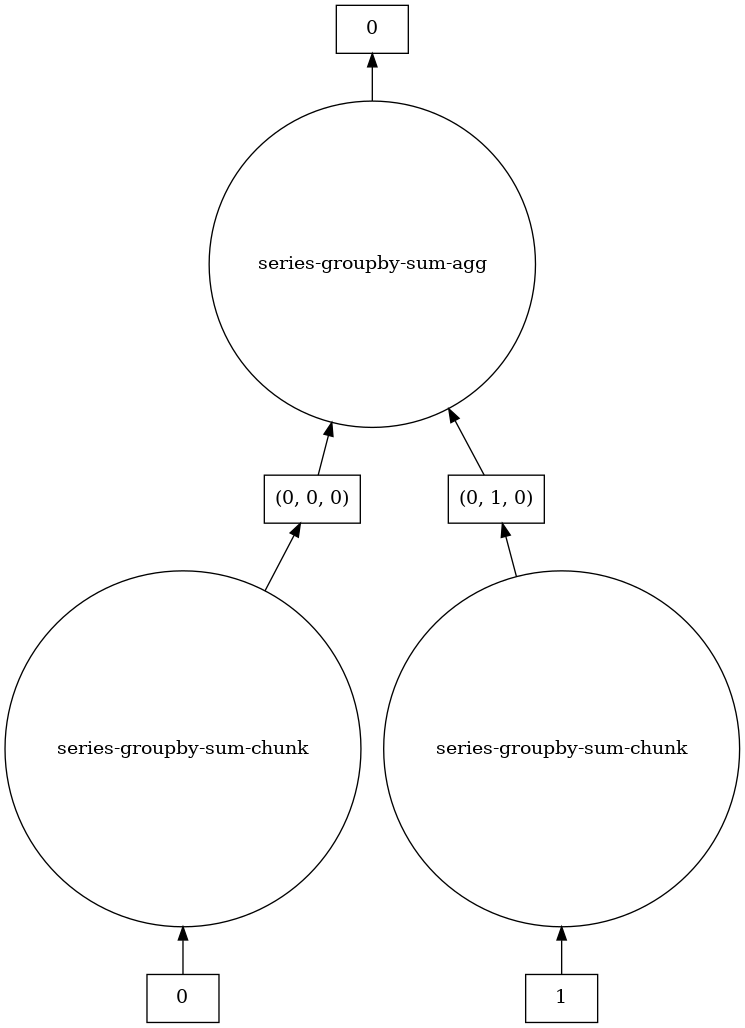

In [43]:
grp.visualize()

# Diagnostic

In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed, compute

cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39171 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


In [5]:
print(client)

<Client: 'tcp://127.0.0.1:43737' processes=4 threads=4, memory=16.50 GB>


In [4]:
import time

def inc(x):
    time.sleep(1)
    return x + 1

In [5]:
to_compute = delayed(sum)([delayed(inc)(x) for x in range(100)])

In [7]:
result = compute(to_compute)

In [12]:
from dask.distributed import progress

In [14]:
to_compute = to_compute.persist()

In [16]:
client.restart()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:33081 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


In [7]:
client.close()
cluster.close()

In [5]:
from dask.distributed import performance_report

In [6]:
with performance_report(filename="dask-report.html"):
    compute(to_compute)

In [ ]:
from dask.distributed import Client
client = Client()

In [2]:
client

Client Scheduler: tcp://127.0.0.1:42681 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


In [6]:
from dask.diagnostics import ProgressBar
from dask import delayed, compute

In [16]:
import time

def inc(x):
    time.sleep(1)
    return x + 1

In [8]:
to_compute = delayed(sum)([delayed(inc)(x) for x in range(100)])

In [9]:
with ProgressBar():
    to_compute.compute()

# Test local cluster

In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed, compute


In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)

In [4]:
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:32855 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


In [19]:
to_compute = delayed(sum)([delayed(inc)(x) for x in range(100)])
result = compute(to_compute)

In [20]:
to_compute = delayed(sum)([delayed(inc)(x) for x in range(100)])

In [21]:
%%time
result = compute(to_compute)

CPU times: user 4.01 s, sys: 362 ms, total: 4.37 s
Wall time: 25.1 s


In [22]:
cluster.scale(20)

In [23]:
to_compute = delayed(sum)([delayed(inc)(x) for x in range(100)])

In [24]:
%%time
result = compute(to_compute)

CPU times: user 1.52 s, sys: 132 ms, total: 1.66 s
Wall time: 5.19 s


In [15]:
cluster

LocalCluster('tcp://127.0.0.1:32855', workers=10, threads=10, memory=41.24 GB)

In [13]:
cluster.scale(4)

Init signature:
LocalCluster(
    n_workers=None,
    threads_per_worker=None,
    processes=True,
    loop=None,
    start=None,
    host=None,
    ip=None,
    scheduler_port=0,
    silence_logs=30,
    dashboard_address=':8787',
    worker_dashboard_address=None,
    diagnostics_port=None,
    services=None,
    worker_services=None,
    service_kwargs=None,
    asynchronous=False,
    security=None,
    protocol=None,
    blocked_handlers=None,
    interface=None,
    worker_class=None,
    scheduler_kwargs=None,
    **worker_kwargs,
)
Docstring:     
Create local Scheduler and Workers

This creates a "cluster" of a scheduler and workers running on the local
machine.

Parameters
----------
n_workers: int
    Number of workers to start
processes: bool
    Whether to use processes (True) or threads (False).  Defaults to True
threads_per_worker: int
    Number of threads per each worker
scheduler_port: int
    Port of the scheduler.  8786 by default, use 0 to choose a random port
sile